[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


category
3    31900
4    31900
2    31900
1    31900
Name: count, dtype: int64
Average word count: 20.300634796238246
Average sentence length: 1.0


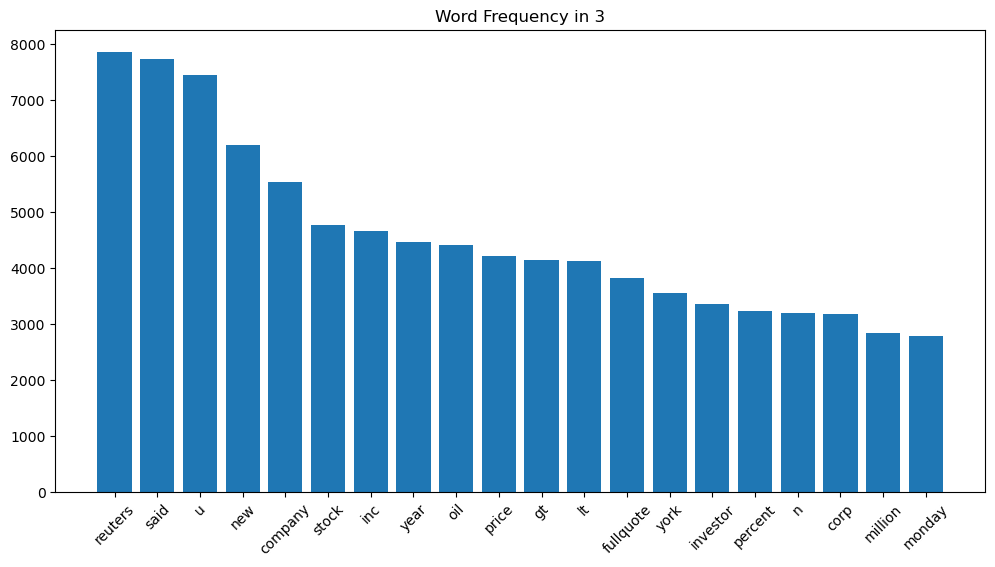

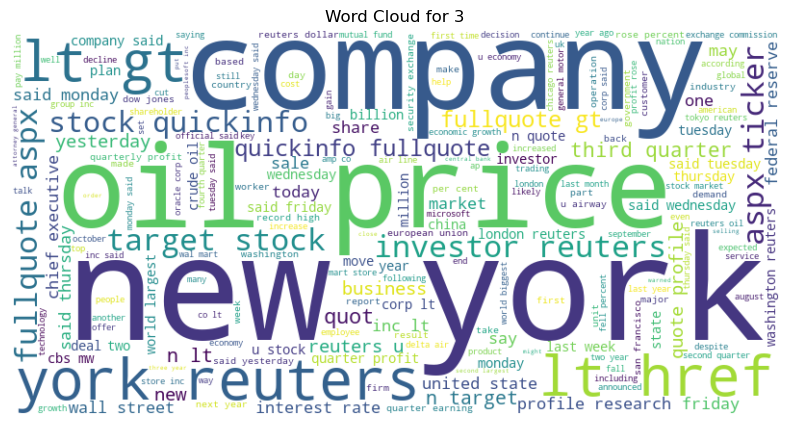

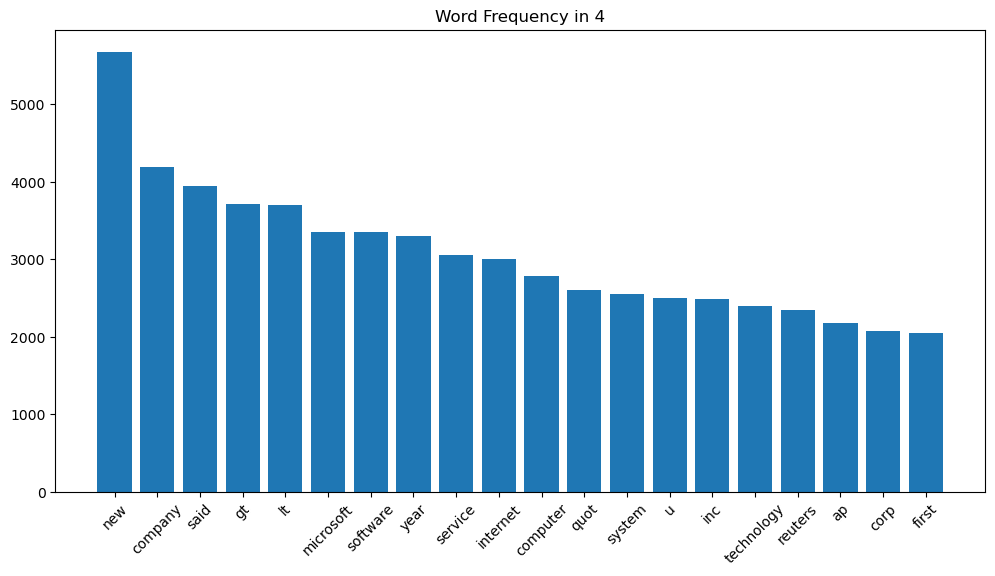

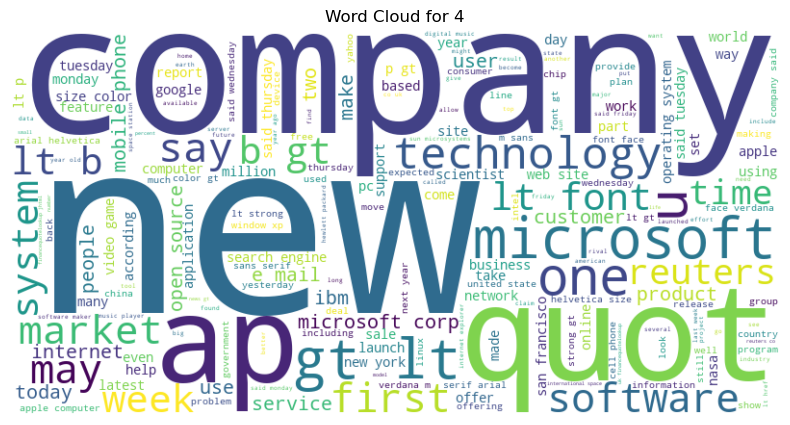

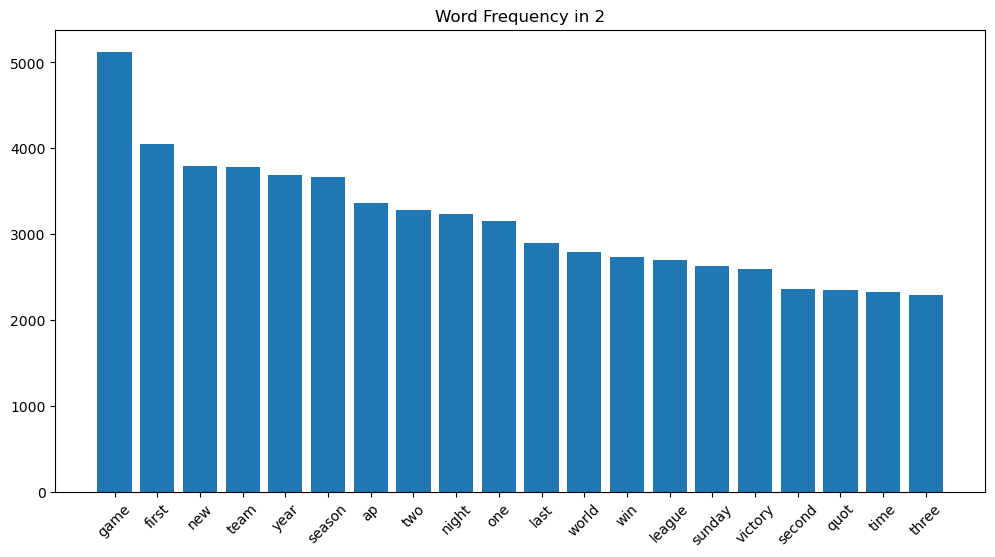

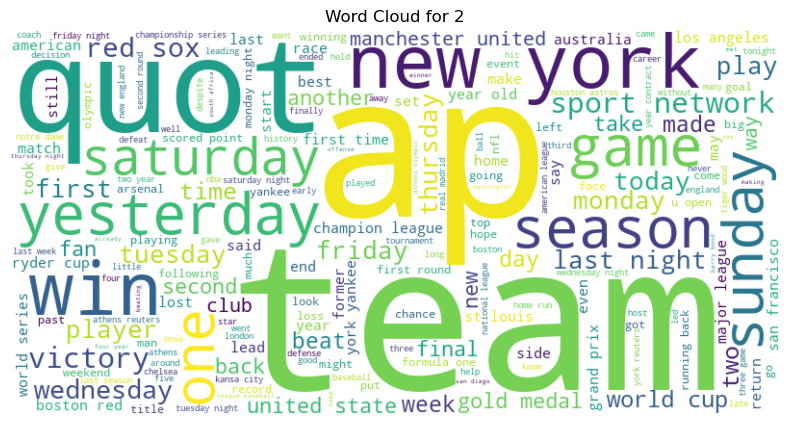

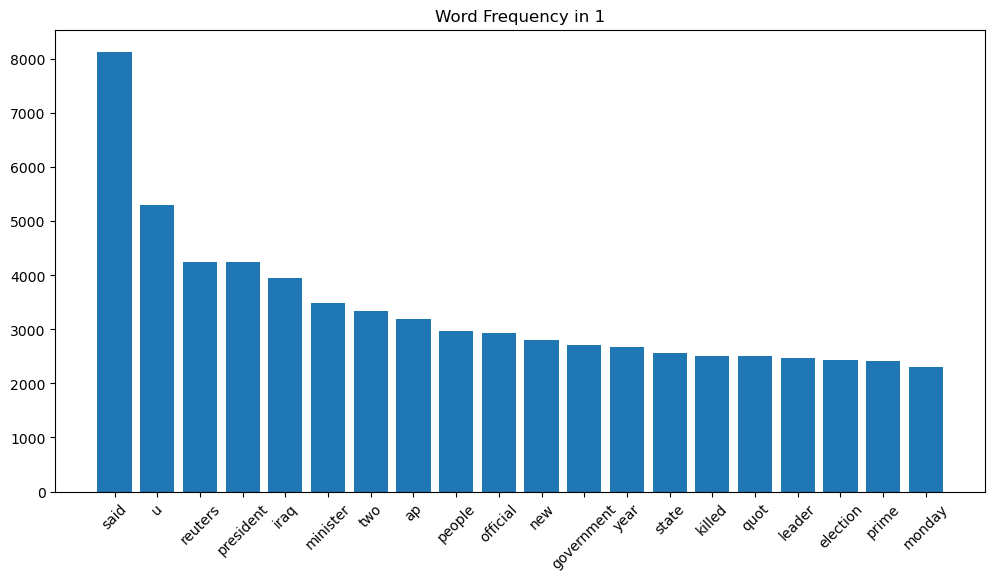

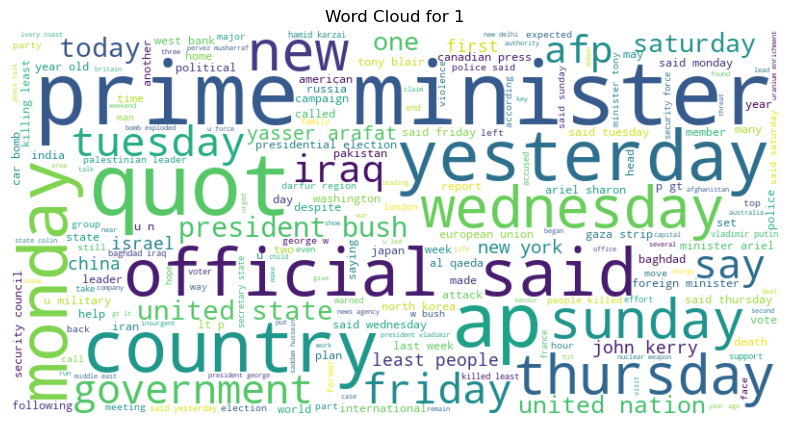

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.87      0.88      6283
           2       0.93      0.97      0.95      6466
           3       0.85      0.84      0.85      6370
           4       0.86      0.85      0.86      6401

    accuracy                           0.88     25520
   macro avg       0.88      0.88      0.88     25520
weighted avg       0.88      0.88      0.88     25520



In [ ]:
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Collect and preprocess news article data (Robust handling of AG News)
try:
    from sklearn.datasets import fetch_openml

    ag_news = fetch_openml(name='ag_news', version=1, as_frame=True)
    df = ag_news.data
    df['category'] = ag_news.target

    # Check for correct column names
    if 'text' not in df.columns:
        # Attempt to find a suitable column for text data
        for col in df.columns:
            if 'text' in col.lower() or 'description' in col.lower() or 'content' in col.lower():
                df.rename(columns={col: 'text'}, inplace=True)
                break
        else:
            print("Error: Could not find a suitable text column in the AG News dataset.")
            exit()

except Exception as e:
    print(f"Error loading AG News dataset: {e}")
    exit()

# 2. Preprocess the text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Handle non-string values
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

# 3. Analyze: Distribution, word count, sentence length, word frequency
print(df['category'].value_counts())

df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
df['sentence_length'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(str(x))))

print(f"Average word count: {df['word_count'].mean()}")
print(f"Average sentence length: {df['sentence_length'].mean()}")

def visualize_word_frequency(df, category):
    category_text = ' '.join(df[df['category'] == category]['processed_text'])
    words = category_text.split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.title(f"Word Frequency in {category}")
    plt.xticks(rotation=45)
    plt.show()

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {category}")
    plt.show()

for cat in df['category'].unique():
    visualize_word_frequency(df, cat)

# 4. Text Classification and rest of the code remains the same.
# ... (rest of your code)

# 4. Text Classification
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['category'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

# SVM
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Deep Learning (LSTM)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=200)
X_test_padded = pad_sequences(X_test_seq, maxlen=200)

lstm_model = Sequential([
    Embedding(5000, 128, input_length=200),
    LSTM(128),
    Dense(len(df['category'].unique()), activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_padded, np.array(y_train).astype('int'), epochs=5, validation_data=(X_test_padded, np.array(y_test).astype('int')))
lstm_predictions = np.argmax(lstm_model.predict(X_test_padded), axis=-1)
print("LSTM Classification Report:\n", classification_report(y_test, lstm_predictions, zero_division=0))

# Deep Learning (CNN)
cnn_model = Sequential([
    Embedding(5000, 128, input_length=200),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(len(df['category'].unique()), activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_padded, np.array(y_train).astype('int'), epochs=5, validation_data=(X_test_padded, np.array(y_test).astype('int')))
cnn_predictions = np.argmax(cnn_model.predict(X_test_padded), axis=-1)
print("CNN Classification Report:\n", classification_report(y_test, cnn_predictions, zero_division=0))

# 6. Text Summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text, max_length=150, min_length=30):
    try:
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)[0]['summary_text']
        return summary
    except Exception as e:
        print(f"Error during summarization: {e}")
        return "Summary could not be generated."

sample_text = df['text'].iloc[0]
abstractive_summary = summarize_text(sample_text)
print(f"Original Text:\n{sample_text}\n")
print(f"Abstractive Summary:\n{abstractive_summary}")

# Example of Extractive summarization using nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

def extractive_summarize(text, top_n=3):
    sentences = sent_tokenize(text)
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(sentence_vectors)
    graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(graph)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = ' '.join([s for _, s in ranked_sentences[:top_n]])
    return summary

extractive_summary = extractive_summarize(sample_text)
print(f"\nExtractive Summary:\n{extractive_summary}")

In [13]:
pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/301.2 kB 393.8 kB/s eta 0:00:01
   ------------------------- -------------- 194.6/301.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------  297.0/301.2 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install transformers


   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
    --------------------------------------- 0.2/10.2 MB 4.1 MB/s eta 0:00:03
   - -------------------------------------- 0.4/10.2 MB 5.1 MB/s eta 0:00:02
   - -------------------------------------- 0.5/10.2 MB 3.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/10.2 MB 3.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/10.2 MB 3.0 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/10.2 MB 3.0 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/10.2 MB 2.5 MB/s eta 0:00:04
   --- ------------------------------------ 0.9/10.2 MB 2.5 MB/s eta 0:00:04
   ---- ----------------------------------- 1.2/10.2 MB 2.9 MB/s eta 0:00:04
   ---- ----------------------------------- 1.2/10.2 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/10.2 MB 2.5 MB/s eta 0:00:04
   ----- ---------------------------------- 1.3/10.2 MB 2.4 MB/s eta 0:00:04
   --